In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Extract emotion labels

In [ ]:
import re
from pathlib import Path
import os
import pickle
import numpy as np

# Initialize the dictionary to hold file transcriptions
transcriptionsdict = dict()
# Define the regex pattern to capture the audio code
audio_code_regex = re.compile(r'^(\S+)\s')
# Define the regex pattern to capture the transcription part
transcription_regex = re.compile(r':\s*(.*)$')

# Loop through each session
for numsess in range(1, 6):
    dir_transcripts = "/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session"+str(numsess)+"/dialog/transcriptions/"

    txt_transcripts = os.listdir(dir_transcripts)
    # Loop through each file in the directory
    for file in txt_transcripts:
        # Ensure we are reading a file
        # Open and read the file
        b = dir_transcripts + file
        with open(b,'r') as f:
            text = f.readlines()

        # Process each line in the file
        for line in text:
            audio_match = re.search(audio_code_regex, line)
            match_transcription = re.search(transcription_regex, line)
            if audio_match and match_transcription:
                audio_key = audio_match.groups()[0]
                transcription_value = match_transcription.groups()[0].strip()
                # Add the audio code and transcription to the dictionary
                #assuming keys unique
                transcriptionsdict.update({audio_key: transcription_value})

In [ ]:
import re as reg
import os
import pandas as pd
from pathlib import Path

emotion_dict = {
    'ang': 0,
    'hap': 1,
    'exc': 2,
    'sad': 3,
    'fru': 4,
    'fea': 5,
    'sur': 6,
    'neu': 7,
    'xxx': 8,
    'oth': 8
}

def parse_main_info(line):
    """
    Parses the main info line to extract start time, end time, file name, emotion, and VAD values.
    """
    main_info_pattern = re.compile(r'\[(\d+\.\d+) - (\d+\.\d+)\]\t([^\t]+)\t([^\t]+)\t\[(\d+\.\d+), (\d+\.\d+), (\d+\.\d+)\]')
    match = main_info_pattern.match(line)

    if match:
        time_init, final_time, fine_name_wv, sentiment, valence, activation, dominance = match.groups()
        time_init = float(time_init)
        final_time = float(final_time)
        valence = float(valence)
        activation = float(activation)
        dominance = float(dominance)
        sentiment = emotion_dict.get(sentiment, 8)  # Default to 8 if emotion not found

        return time_init, final_time, fine_name_wv, sentiment, valence, activation, dominance
    return None

def extract_info():
    # Collect data in a list of tuples
    info_list = []

    for num_sess in range(1, 6):
        emo_evaluation_dir = Path(f'/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/Session{num_sess}/dialog/EmoEvaluation/')
        files_eval = list(emo_evaluation_dir.glob('Ses*'))

        for file_path in files_eval:
            with file_path.open() as f:
                text = f.read()
                lines = text.split('\n')
                for line in lines:
                    if line=="% [START_TIME - END_TIME] TURN_NAME EMOTION [V, A, D]":
                        continue
                    main_info = parse_main_info(line)
                    if main_info:
                        info_list.append(main_info)

    # Convert list of tuples to dictionary
    info_dict = {
        'start_times': [info[0] for info in info_list],
        'end_times': [info[1] for info in info_list],
        'wav_file_names': [info[2] for info in info_list],
        'emotions': [info[3] for info in info_list],
        'vals': [info[4] for info in info_list],
        'acts': [info[5] for info in info_list],
        'doms': [info[6] for info in info_list]
    }

    # Output the results
    print(info_dict)
    return info_dict

def compile_dataset(info_dict):
    """
    Creates a CSV file from info_dict which will serve as the dataset

    compile_dataset: Dict -> None
    """
    iemo_df = pd.DataFrame(info_dict)

    # Ensure the output directory exists
    output_path = Path('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata')
    output_path.mkdir(parents=True, exist_ok=True)

    # Save to a CSV file
    iemo_df.to_csv(output_path / 'df_iemocap.csv', index=False)
    print(iemo_df.head())
# Run the extraction and compilation
compile_dataset(extract_info())


{'start_times': [18.9629, 30.32, 58.04, 63.13, 67.02, 70.69, 96.27, 101.33, 128.555, 153.51, 161.6249, 165.8, 174.7, 177.96, 182.11, 193.62, 196.48, 215.1712, 237.74, 248.99, 273.98, 276.94, 304.42, 319.61, 402.01, 3.3988, 9.0475, 21.1025, 26.9072, 31.79, 41.8225, 52.6225, 59.45, 65.72, 69.41, 74.89, 82.2739, 88.32, 97.9122, 107.27, 125.1356, 134.91, 138.49, 155.54, 158.38, 163.6278, 168.02, 176.49, 179.8, 183.82, 192.12, 195.3, 200.4, 205.8575, 223.594, 247.92, 250.59, 266.4, 275.5, 279.69, 289.53, 297.08, 317.78, 321.24, 326.882, 338.9269, 347.115, 356.01, 367.32, 375.8875, 383.78, 393.63, 4.8285, 12.3484, 17.1566, 28.31, 38.32, 42.82, 49.1, 63.01, 69.64, 87.61, 97.02, 98.9525, 108.9225, 117.0, 137.289, 146.98, 153.3875, 159.06, 162.8, 169.69, 186.209, 196.14, 200.92, 212.5813, 218.54, 225.04, 240.62, 247.48, 259.13, 266.31, 270.66, 344.18, 415.8011, 422.467, 432.557, 459.57, 8.59, 26.0445, 36.1709, 41.0, 47.21, 54.62, 67.6792, 78.08, 98.07, 106.5092, 115.2878, 126.68, 142.91, 151.03

#2. Data preprocessing

In [ ]:
def insert_space_before_punctuation(s):
    result = []
    for char in s:
        if char in '.!?':
            result.append(' ')
        result.append(char)
    return ''.join(result)

In [ ]:
import nltk
nltk.download('stopwords')
#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import scipy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
!python3 -m textblob.download_corpora

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
# Stop words

def tweet_normalization(text):
    # convert text to lowercase
    text = text.lower()
    text = insert_space_before_punctuation(text)
    # remove non alphanumeric character
    text = re.sub(r'[^A-Za-z0-9.!?]+', ' ', text)
    #lematization techniques
    lemmatizer = WordNetLemmatizer()
    # stop words definition
    stop_words = nltk.corpus.stopwords.words('english')
    # combine all previous methods in order to clear the text
    result = ' '.join(
        lemmatizer.lemmatize(term)#term
        for term in text.split()
        if term not in set(stop_words)
    )
    #filtered_words = ' '.join(word for word in text.split() if word not in set(stop_words))
    #result = filtered_words
    #result=text

    return result

In [ ]:
def preprocess(input_df):
    # Remove rows with missing values in column col
    input_df.dropna(inplace=True)
    # Speed up code using numpy vectorization
    vfunc = np.vectorize(tweet_normalization)
    input_df['new_transcription'] = vfunc(input_df.transcription)
    # return processed input_df
    return input_df

In [ ]:
df_iemo = pd.read_csv('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/df_iemocap.csv')
# Prepare text data
df_text = pd.DataFrame()
pd.set_option('display.max_colwidth', None)
df_text['wav_file_names'] = df_iemo['wav_file_names']
df_text['transcription'] = [transcriptionsdict[code] for code in df_text['wav_file_names']]
df_text2 = preprocess(df_text)
df_text2.head()


,wav_file_names,transcription,new_transcription
0,Ses01M_script02_1_F000,I'm fine.,fine .
1,Ses01M_script02_1_F001,Ugh...,ugh . . .
2,Ses01M_script02_1_F002,What flashlight?,flashlight ?
3,Ses01M_script02_1_F003,That's not your flashlight.,flashlight .
4,Ses01M_script02_1_F004,"It's ours; it's my flashlight, too.",flashlight .


In [ ]:
# Define the path to the CSV file
file_path = Path('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/df_iemocap.csv')

# Load the dataset from the CSV file
dataset = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(dataset.head())
df_text2['label'] = dataset['emotions']

df_text2['label'] = df_text2['label'].replace({3: 2, 4: 2, 5: 3, 6: 4, 7: 5, 0: 0, 1: 1, 2: 1})
# Remove rows with the specific label
df_text2 = df_text2[df_text2['label'] != 8]
df_text2[:10]


   start_times  end_times          wav_file_names  emotions  vals  acts  doms
0      18.9629      20.82  Ses01M_script02_1_F000         8   3.0   3.0   3.0
1      30.3200      32.05  Ses01M_script02_1_F001         4   1.5   3.5   3.5
2      58.0400      60.01  Ses01M_script02_1_F002         6   2.0   2.5   3.5
3      63.1300      65.78  Ses01M_script02_1_F003         8   2.0   3.0   4.0
4      67.0200      69.82  Ses01M_script02_1_F004         8   2.0   3.5   4.0


,wav_file_names,transcription,new_transcription,label
1,Ses01M_script02_1_F001,Ugh...,ugh . . .,2
2,Ses01M_script02_1_F002,What flashlight?,flashlight ?,4
5,Ses01M_script02_1_F005,"You keep saying ""my flashlight"" like somehow it's just yours. How's that supposed to make me feel?",keep saying flashlight like somehow . supposed make feel ?,0
7,Ses01M_script02_1_F007,No.,.,5
8,Ses01M_script02_1_F008,I'm fine.,fine .,5
9,Ses01M_script02_1_F009,I wonder if they can hear me talk,wonder hear talk,1
10,Ses01M_script02_1_F010,I'm cold.,cold .,2
11,Ses01M_script02_1_F011,"It's after eleven, let's go home.",eleven let go home .,2
12,Ses01M_script02_1_F012,There is no point.,point .,2
13,Ses01M_script02_1_F013,That's my point.,point .,2


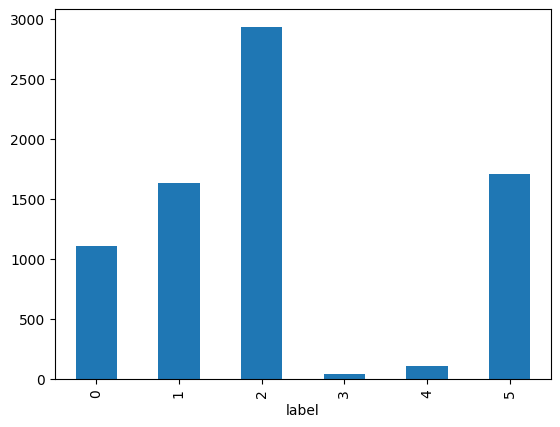

In [ ]:
import matplotlib.pyplot as plt

# Group the data by the 'label' column
label_groups = df_text2.groupby('label')

# Count the number of transcriptions in each group
transcription_counts = label_groups['transcription'].count()

# Plot the counts as a bar chart with the y-axis starting at 0
ax = transcription_counts.plot(kind='bar', ylim=(0))

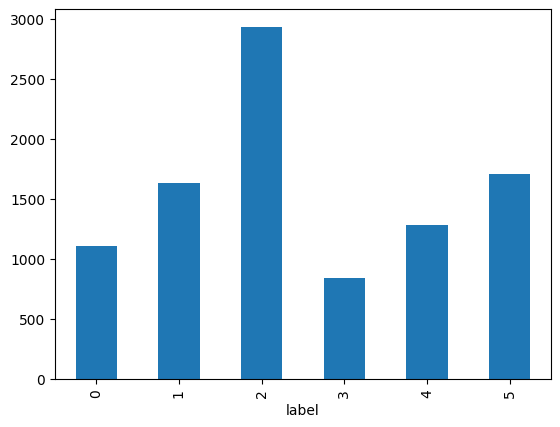

In [ ]:
# oversample fear
fear_df = df_text2[df_text2['label'].isin([3])]
for i in range(20):
    df_text2 = pd.concat([df_text2, fear_df], ignore_index=True)

sur_df = df_text2[df_text2['label'].isin([4])]
for i in range(11):
    df_text2 = pd.concat([df_text2, sur_df], ignore_index=True)

# Group the data by the 'label' column
label_groups = df_text2.groupby('label')

# Count the number of transcriptions in each group
transcription_counts = label_groups['transcription'].count()

# Plot the counts as a bar chart with the y-axis starting at 0
ax = transcription_counts.plot(kind='bar', ylim=(0))

In [ ]:
0.8*9504
df_text2.to_csv('/content/drive/My Drive/ML_mscdata/IEMOCAP_full_release/IEMOCAP_full_release/preprocesseddata/df_iemocap_oversampling.csv', index=False)
df_text2.shape

(9504, 4)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
tfidf_vectors = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words='english') #latin-1

feature_vectors = tfidf_vectors.fit_transform(df_text2.transcription).toarray()

label_values = df_text2.label
print(feature_vectors.shape)

(9504, 2464)


In [ ]:
from sklearn.model_selection import train_test_split
x_train_text, x_test_text, y_train_text, y_test_text = train_test_split(feature_vectors, label_values, test_size=0.20)

#3. Models

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
randomforest_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
randomforest_classifier.fit(x_train_text, y_train_text)

y_predict_lr3 = randomforest_classifier.predict(x_test_text)

print('Accuracy Score:', accuracy_score(y_test_text, y_predict_lr3))

#Create classification report
class_report=classification_report(y_test_text, y_predict_lr3)
print(class_report)


Accuracy Score: 0.6123093108890058
              precision    recall  f1-score   support

           0       0.70      0.38      0.49       223
           1       0.70      0.51      0.59       307
           2       0.56      0.69      0.61       601
           3       0.86      0.77      0.81       159
           4       0.62      0.99      0.76       269
           5       0.51      0.36      0.42       342

    accuracy                           0.61      1901
   macro avg       0.66      0.61      0.61      1901
weighted avg       0.62      0.61      0.60      1901



In [ ]:
C = np.array(confusion_matrix(y_test_text, y_predict_lr3))

confmtrx = pd.DataFrame(C, index=['angry, true','happy, true','sad, true','fear, true','sur, true','neutral, true'],
                        columns=['angry, predicted','happy, predicted','sad, predicted','fear, predicted','sur, predicted','neutral, predicted'])

confmtrx.loc['sum'] = confmtrx.sum()
confmtrx['sum'] = confmtrx.sum(axis=1)
confmtrx

,"angry, predicted","happy, predicted","sad, predicted","fear, predicted","sur, predicted","neutral, predicted",sum
"angry, true",84,12,94,0,15,18,223
"happy, true",3,156,94,5,21,28,307
"sad, true",28,29,413,7,51,73,601
"fear, true",0,0,0,122,37,0,159
"sur, true",0,0,0,3,266,0,269
"neutral, true",5,26,143,5,40,123,342
sum,120,223,744,142,430,242,1901


In [ ]:
print(y_predict_lr3)

[4 3 3 ... 2 1 1]


AUC for class ang: 0.6776137511558176
AUC for class hap: 0.7330553500709092
AUC for class sad: 0.7162863176756686
AUC for class fea: 0.8779072706135506
AUC for class sur: 0.9441786937823455
AUC for class neu: 0.6416590707043427


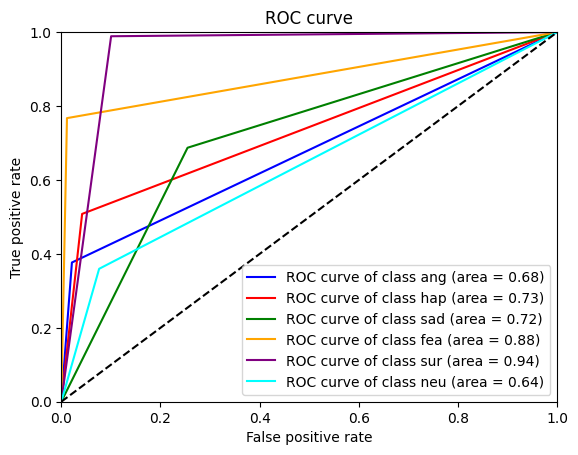

In [ ]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Define class names
class_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']

# Convert y_predict_lr3 to a one-hot encoded format
n_classes = len(class_names)
y_pred_one_hot = np.zeros((y_predict_lr3.size, n_classes))
y_pred_one_hot[np.arange(y_predict_lr3.size), y_predict_lr3.astype(int)] = 1

# Initialize lists to store false positive rates, true positive rates, and AUCs
fprs = []
tprs = []
aucs = []

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    # Compute the ROC curve and AUC for the i-th class
    fpr, tpr, _ = metrics.roc_curve(y_test_text == i, y_pred_one_hot[:, i])
    auc = metrics.auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)
    print(f"AUC for class {class_names[i]}: {auc}")

# Plotting the ROC curves
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan']
plt.figure()

for i in range(n_classes):
    plt.plot(fprs[i], tprs[i], color=colors[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], aucs[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()


## Multinomial NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

multinaivebayes_classifier = MultinomialNB()

multinaivebayes_classifier.fit(x_train_text, y_train_text)

y_predict_lr4 = multinaivebayes_classifier.predict(x_test_text)

print('Accuracy Score:', accuracy_score(y_test_text, y_predict_lr4))

#Create classification report
class_report2=classification_report(y_test_text, y_predict_lr4)
print(class_report2)


Accuracy Score: 0.5865334034718569
              precision    recall  f1-score   support

           0       0.76      0.35      0.48       223
           1       0.70      0.54      0.61       307
           2       0.46      0.81      0.59       601
           3       0.87      0.64      0.73       159
           4       0.90      0.68      0.78       269
           5       0.53      0.30      0.38       342

    accuracy                           0.59      1901
   macro avg       0.70      0.55      0.59      1901
weighted avg       0.64      0.59      0.58      1901



In [ ]:
C = np.array(confusion_matrix(y_test_text, y_predict_lr4))

confmtrx = pd.DataFrame(C, index=['angry, true','happy, true','sad, true','fear, true','sur, true','neutral, true'],
                        columns=['angry, predicted','happy, predicted','sad, predicted','fear, predicted','sur, predicted','neutral, predicted'])

confmtrx.loc['sum'] = confmtrx.sum()
confmtrx['sum'] = confmtrx.sum(axis=1)
confmtrx

,"angry, predicted","happy, predicted","sad, predicted","fear, predicted","sur, predicted","neutral, predicted",sum
"angry, true",77,15,113,0,4,14,223
"happy, true",0,166,109,8,4,20,307
"sad, true",23,27,486,3,5,57,601
"fear, true",0,0,55,101,3,0,159
"sur, true",0,0,85,0,184,0,269
"neutral, true",1,28,204,4,4,101,342
sum,101,236,1052,116,204,192,1901


AUC for class ang: 0.6654943692309336
AUC for class hap: 0.748400966163831
AUC for class sad: 0.686633815435812
AUC for class fea: 0.8133046667966409
AUC for class sur: 0.8358799839638458
AUC for class neu: 0.6184754434729114


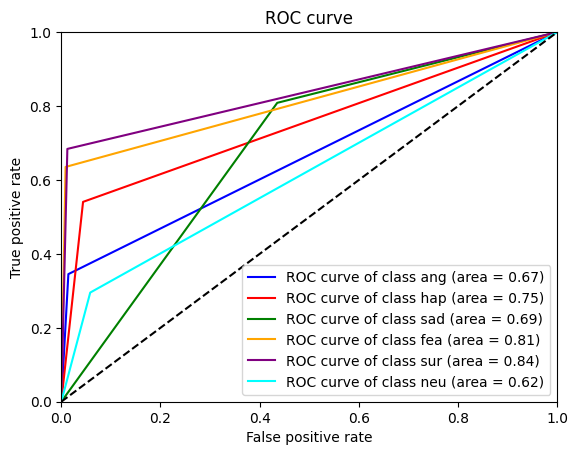

In [ ]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Define class names
class_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']

# Convert y_predict_lr4 to a one-hot encoded format
n_classes = len(class_names)
y_pred_one_hot = np.zeros((y_predict_lr4.size, n_classes))
y_pred_one_hot[np.arange(y_predict_lr4.size), y_predict_lr4.astype(int)] = 1

# Initialize lists to store false positive rates, true positive rates, and AUCs
fprs = []
tprs = []
aucs = []

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    # Compute the ROC curve and AUC for the i-th class
    fpr, tpr, _ = metrics.roc_curve(y_test_text == i, y_pred_one_hot[:, i])
    auc = metrics.auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)
    print(f"AUC for class {class_names[i]}: {auc}")

# Plotting the ROC curves
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan']
plt.figure()

for i in range(n_classes):
    plt.plot(fprs[i], tprs[i], color=colors[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], aucs[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()


## Logistic Regression

In [ ]:
logisticreg_classifer = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
logisticreg_classifer.fit(x_train_text, y_train_text)

y_predict_lr5 = logisticreg_classifer.predict(x_test_text)

print('Accuracy Score:', accuracy_score(y_test_text, y_predict_lr5))

#Create classification report
class_report3=classification_report(y_test_text, y_predict_lr5)
print(class_report3)

Accuracy Score: 0.6102051551814834
              precision    recall  f1-score   support

           0       0.69      0.42      0.52       223
           1       0.68      0.59      0.63       307
           2       0.50      0.74      0.60       601
           3       0.89      0.73      0.80       159
           4       0.83      0.77      0.80       269
           5       0.50      0.35      0.41       342

    accuracy                           0.61      1901
   macro avg       0.68      0.60      0.63      1901
weighted avg       0.63      0.61      0.61      1901



## XGBoost

In [ ]:
import xgboost
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

model_xgb = xgboost.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob',
                                   n_estimators=600, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
model_xgb.fit(x_train_text, y_train_text)

y_predict_lr6 = model_xgb.predict(x_test_text)

print('Accuracy Score:', accuracy_score(y_test_text, y_predict_lr6))

class_report4=classification_report(y_test_text, y_predict_lr6)
print(class_report4)

Accuracy Score: 0.5476065228826933
              precision    recall  f1-score   support

           0       0.68      0.21      0.32       223
           1       0.75      0.36      0.48       307
           2       0.42      0.87      0.57       601
           3       0.91      0.73      0.81       159
           4       0.93      0.58      0.72       269
           5       0.59      0.26      0.36       342

    accuracy                           0.55      1901
   macro avg       0.71      0.50      0.54      1901
weighted avg       0.65      0.55      0.53      1901



In [ ]:
# Predict
pred_probs1 = randomforest_classifier.predict_proba(x_test_text)
pred_probs2 = multinaivebayes_classifier.predict_proba(x_test_text)
pred_probs3 = logisticreg_classifer.predict_proba(x_test_text)
pred_probs4 = model_xgb.predict_proba(x_test_text)
print(pred_probs1)

[[9.05977186e-02 6.32842860e-02 2.23397242e-01 2.14315531e-01
  2.77813600e-01 1.30591623e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.25710674e-03 4.77902483e-02 1.10527764e-02 8.49488662e-01
  0.00000000e+00 8.84112069e-02]
 ...
 [2.15848404e-02 2.30149963e-01 4.60343888e-01 0.00000000e+00
  9.45980543e-04 2.86975328e-01]
 [2.22005459e-02 7.07942884e-01 1.55585313e-01 0.00000000e+00
  1.67984629e-03 1.12591411e-01]
 [4.54563221e-02 6.71107194e-01 1.65943499e-01 3.47907851e-04
  4.27832628e-04 1.16717245e-01]]


In [ ]:
# Average of the predicted probabilites
averaging = (pred_probs1 +
                       pred_probs2 +
                       pred_probs3 +
                       pred_probs4)/4.0

print(averaging)
pred_new = np.argmax(averaging, axis=-1)
print(pred_new)

[[0.11653705 0.13773034 0.28080135 0.1143643  0.17474214 0.17582482]
 [0.01302851 0.01785493 0.02154054 0.92841234 0.00925124 0.00991245]
 [0.01949348 0.0417882  0.0380292  0.80715008 0.01684392 0.07669511]
 ...
 [0.04250196 0.19878643 0.36930444 0.01796806 0.06190057 0.30953854]
 [0.04074942 0.57891016 0.17028724 0.01403409 0.04243123 0.15358786]
 [0.07861032 0.60343148 0.14233113 0.0290877  0.03337714 0.11316225]]
[2 3 3 ... 2 1 1]


In [ ]:
class_report5=classification_report(y_test_text, pred_new)
print(class_report5)

              precision    recall  f1-score   support

           0       0.75      0.36      0.48       223
           1       0.73      0.56      0.63       307
           2       0.49      0.77      0.60       601
           3       0.89      0.73      0.80       159
           4       0.83      0.78      0.81       269
           5       0.50      0.32      0.39       342

    accuracy                           0.61      1901
   macro avg       0.70      0.59      0.62      1901
weighted avg       0.64      0.61      0.60      1901



In [ ]:
C = np.array(confusion_matrix(y_test_text, pred_new))

confmtrx = pd.DataFrame(C, index=['angry, true','happy, true','sad, true','fear, true','sur, true','neutral, true'],
                        columns=['angry, predicted','happy, predicted','sad, predicted','fear, predicted','sur, predicted','neutral, predicted'])

confmtrx.loc['sum'] = confmtrx.sum()
confmtrx['sum'] = confmtrx.sum(axis=1)
confmtrx

,"angry, predicted","happy, predicted","sad, predicted","fear, predicted","sur, predicted","neutral, predicted",sum
"angry, true",80,10,111,0,4,18,223
"happy, true",0,172,99,7,5,24,307
"sad, true",25,23,465,3,18,67,601
"fear, true",0,0,43,116,0,0,159
"sur, true",0,0,58,0,211,0,269
"neutral, true",2,32,178,4,17,109,342
sum,107,237,954,130,255,218,1901


In [ ]:
print('Accuracy Score:', accuracy_score(y_test_text, np.array(pred_new)))

Accuracy Score: 0.6065228826933193
